In [1]:
import sys
import os
import json

from core.data.data_loader import *
from core.models.lstm import ModelLSTM, ModelLSTMParalel
from core.data.data_loader import FeatureType, Dataset


from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import set_random_seed

import keras.backend as K
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


## loading Configurartion ##


In [5]:
# load some configurations configurations of model and others

configs = json.load(open('config-paralel.json', 'r'))
save_dir = configs['paths']['save_dir']
save_fname = os.path.join(save_dir, 'architecture-%s.png' % configs['model']['name'])
save_fnameh5 = os.path.join(save_dir, 'model-%s.h5' % configs['model']['name'])
print(save_fname) 
print(save_fnameh5)
print('OK reading of json file')

results/architecture-lstm-paralel.png
results/model-lstm-paralel.h5
OK reading of json file


## Setup Data ##

In [6]:
# reading path of data
#path = './dataset/2020_100_sorted.csv'
#path = './dataset/event_2000_2020_train.csv'
#path = './dataset/events.csv'
#path = './dataset/phi025-025_eta025-025/phi025-025_eta025-025_filtered.csv'
path = configs['data']['filename']
path

'/data/track-ml/phi025-025_eta025-025/phi025-025_eta025-025_filtered.csv'

In [7]:
data = Dataset(path, KindNormalization.Zscore)

X, X_, y = data.prepare_training_data(FeatureType.Divided, normalise=True,
                                                  cilyndrical=False)
#X, y = data.prepare_training_data(FeatureType.Positions, normalise=False,
#                                                  cilyndrical=False)

X.head()

[Data] data loaded from  /data/track-ml/phi025-025_eta025-025/phi025-025_eta025-025_filtered.csv
[Data] shape datas X:  (15192, 16)
[Data] shape data y:  (15192, 3)
[Data] len data total: 15192


,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3
0,-0.197514,0.447192,0.215793,-0.207645,0.504261,0.094703,-0.209314,0.480264,0.034145,-0.223646,0.405745,-0.000333
1,-0.225104,0.905615,0.454577,-0.241666,1.113409,0.434772,-0.235227,1.182940,0.395443,-0.259084,1.195713,0.362829
2,-0.219544,-0.252188,0.829579,-0.215628,-0.310552,0.963034,-0.215073,-0.304692,0.962387,-0.224862,-0.266718,0.952794
3,3.086830,5.527004,1.322880,3.267902,4.838781,1.578658,3.266429,4.533334,1.620158,3.406857,4.364378,1.654012
4,-0.195694,0.416933,0.610438,-0.207160,0.495587,0.689542,-0.218343,0.513846,0.680414,-0.234667,0.513960,0.667967


In [51]:
X_.head()

,value_0,value_1,value_2,value_3
0,-0.530131,-0.384368,-0.071757,-0.105463
1,0.471253,1.150650,2.437524,-0.382211
2,0.542328,1.196377,2.601919,-0.309291
3,0.473951,0.955227,2.293050,0.717854
4,-0.629905,-0.601838,-0.364456,-0.259654


In [52]:
# existe dados vazios?
X.isnull().values.any()
#dataset.isnull().sum()
X.isna().sum()

x_0    0
y_0    0
z_0    0
x_1    0
y_1    0
z_1    0
x_2    0
y_2    0
z_2    0
x_3    0
y_3    0
z_3    0
dtype: int64

In [8]:
# reshape data     
time_steps =  configs['model']['layers'][0]['input_timesteps']  # the number of points or hits
num_features = configs['model']['layers'][0]['input_features']  # the number of features of each hits

X = data.reshape3d(X, time_steps, num_features)
X_ = data.reshape3d(X_, time_steps, 1)

# always the same info 
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, X_train_, X_test_, y_train, y_test = train_test_split(X, X_, y,
                                                                       test_size=1-0.8, random_state=42)

print('[Data] shape X_train ', X_train.shape)
print('[Data] shape X_test ', X_test.shape)
print('[Data] shape y_train ', y_train.shape)
print('[Data] shape y_test ', y_test.shape)



[Data] shape X_train  (12153, 4, 3)
[Data] shape X_test  (3039, 4, 3)
[Data] shape y_train  (12153, 3)
[Data] shape y_test  (3039, 3)


In [9]:
   
def no_gpu():
    import os
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"
    import tensorflow as tf

    config=tf.ConfigProto(log_device_placement=True)
    sess = tf.Session(config=config)
    set_session(sess)
    

def gpu():
    import tensorflow as tf
    from tensorflow import set_random_seed

    import keras.backend as K
    from keras.backend.tensorflow_backend import set_session
    
    #configure  gpu_options.allow_growth = True in order to CuDNNLSTM layer work on RTX
    config = tf.ConfigProto(device_count = {'GPU': 0})
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

    set_random_seed(1)

no_gpu()

## Create Model ##

In [10]:
# geramos o modelo
model = ModelLSTMParalel()

model.build_model(configs)
model.save_architecture(save_fname)
  

W0207 14:18:57.925211 140717825075008 deprecation_wrapper.py:119] From /home/sataucuri/.conda/envs/trackml2/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0207 14:18:57.927263 140717825075008 deprecation_wrapper.py:119] From /home/sataucuri/.conda/envs/trackml2/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0207 14:18:57.933791 140717825075008 deprecation_wrapper.py:119] From /home/sataucuri/.conda/envs/trackml2/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



[Model] Creating model..


W0207 14:18:59.030323 140717825075008 deprecation_wrapper.py:119] From /home/sataucuri/.conda/envs/trackml2/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0207 14:18:59.040885 140717825075008 deprecation.py:506] From /home/sataucuri/.conda/envs/trackml2/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0207 14:18:59.097075 140717825075008 deprecation_wrapper.py:119] From /home/sataucuri/.conda/envs/trackml2/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



[Model] Model Compiled with structure: [<tf.Tensor 'input_1:0' shape=(?, 4, 3) dtype=float32>, <tf.Tensor 'input_2:0' shape=(?, 4, 1) dtype=float32>]
Time taken: 0:00:01.216474
[Model] Model Architecture saved at results/architecture-lstm-paralel.png


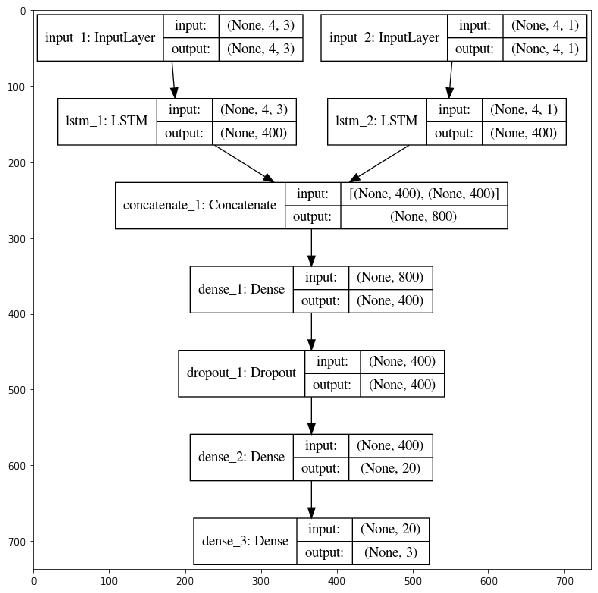

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

fig = plt.figure(figsize=(10, 14))
img=mpimg.imread('results/architecture-lstm-paralel.png')
imgplot = plt.imshow(img)
plt.show()


## Training Model ##

In [57]:
# in-memory training
x_train = [X_train, X_train_]
history = model.train(
    x=x_train,
    y=y_train,
    epochs = 10 ,# configs['training']['epochs'],
    batch_size = 5, #configs['training']['batch_size'],
    save_fname = save_fnameh5
)

[Model] Training Started
[Model] 10 epochs, 5 batch size
Train on 457 samples, validate on 226 samples
Epoch 1/10
457/457 [==============================] - 17s 37ms/step - loss: 0.7552 - acc: 0.5055 - val_loss: 0.7224 - val_acc: 0.4956
Epoch 2/10
457/457 [==============================] - 13s 28ms/step - loss: 0.7057 - acc: 0.5120 - val_loss: 0.7099 - val_acc: 0.4602
Epoch 3/10
457/457 [==============================] - 13s 28ms/step - loss: 0.6944 - acc: 0.5339 - val_loss: 0.7047 - val_acc: 0.4867
Epoch 4/10
457/457 [==============================] - 13s 28ms/step - loss: 0.6936 - acc: 0.5295 - val_loss: 0.7109 - val_acc: 0.4602
Epoch 5/10
457/457 [==============================] - 13s 28ms/step - loss: 0.6909 - acc: 0.5383 - val_loss: 0.7123 - val_acc: 0.4735
[Model] Model for inference saved at results/model-lstm-paralel.h5
[Model] Training Completed. Model saved as results/model-lstm-paralel.h5
[Model] Model tr with structure: [<tf.Tensor 'input_5:0' shape=(?, 4, 3) dtype=float32>

## Evaluate The model ##

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
[Ouput] Validation accuracy: 0.47345133712597653, loss: 0.7122689445329978


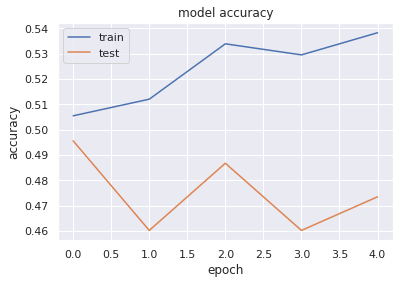

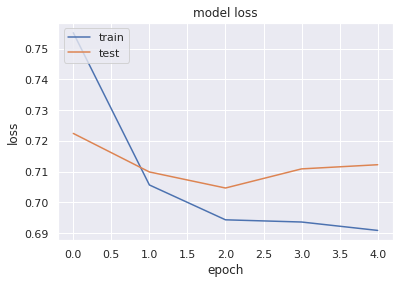

[Output] resulta saved at %s results/eval-loss.png


In [58]:
#evaluate the model
from core.utils.metrics import *
evaluate_training(history,save_dir)

## Prediction ##
We concatenate features to predict one hit.

In [145]:
# Prediction
import numpy as np
from core.utils.metrics import *
from core.utils.utils import *

x_test = [X_test, X_test_]

predicted = model.predict_one_hit(x_test)


[Model] Predicting Point-by-Point...
[Model] Shape predict result (171, 3) size 513


In [153]:
# Convert to original data
#y_predicted = data.reshape2d(predicted, 1)
   
y_predicted = np.reshape(predicted, (predicted.shape[0]*predicted.shape[1], 1))
y_true_ = data.reshape2d(y_test, 1)

result = calc_score(y_true_, y_predicted, report=True)
r2, rmse, rmses = evaluate_forecast(y_test.values, predicted)
summarize_scores(r2, rmse,rmses)


[Output] ---Regression Scores--- 
	R_2 statistics      (R2)  = 0.357
	Mean Square Error   (MSE) = 0.8
	Mean Absolute Error (MAE) = 0.58

RMSE:		[0.800] 
RMSE features: 	[0.64, 1.02, 0.69] 
R^2  features:	[0.54, -0.00, 0.55] 


## Calculate Distances ##

In [154]:
from scipy.spatial import distance
import numpy as np


print('[Data] shape y_test ', y_test.shape)
print('[Data] shape predicted ', predicted.shape)
print('[Data] processing the neardest points between y_real and y_pred...' )

# shortest point with y_pred e y_real
near_points = get_shortest_points(y_test, predicted)
y_near_points = pd.DataFrame(near_points)

#print(y_near_points.head())
print(y_near_points.shape)


[Data] shape y_test  (171, 3)
[Data] shape predicted  (171, 3)
[Data] processing the neardest points between y_real and y_pred...
(171, 3)


In [155]:
# we need to transform to original data
y_test_orig = data.inverse_transform(y_test)
y_predicted_orig = data.inverse_transform(predicted)
y_near_orig = data.inverse_transform(y_near_points)

#print(y_test_orig.shape)
#print(y_predicted_orig.shape)

print('[Data] processing distances for %s vectors..' % y_predicted_orig.shape[0])
dist0 = calculate_distances_matrix(y_predicted_orig, y_test_orig)
#dist1 = calculate_distances_matrix(y_predicted_orig, y_near_orig)
dist1 = calculate_distances_matrix(y_test_orig, y_near_orig)
print('[Data] finished distances..')
print(dist0[0:10])

print(dist1[0:10])


[Data] processing distances for 171 vectors..
[Data] finished distances..
[ 183.18400089  272.40908059 1107.48155085  241.53027098  255.6175005
  453.53499343  157.39767016  209.88959033  285.02647861  340.03886561]
[ 195.75176383  274.05352448 1106.03872745  252.46872277  265.89012208
  467.34216712  346.20234709  331.5915954   606.67944728  318.51879428]


## Ploting Results ##

In [156]:
import plotly.figure_factory as ff
# Group data together
#hist_data = [d1.values.flatten(), d2.values.flatten()]
hist_data = [dist0, dist1]

group_labels = ['Distances predicted', 'Distances Approx']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=.25, curve_type='normal')
#fig = ff.create_distplot(hist_data, group_labels, show_curve=True, bin_size=.2)

fig['layout'].update(title='Distances')

fig.show()

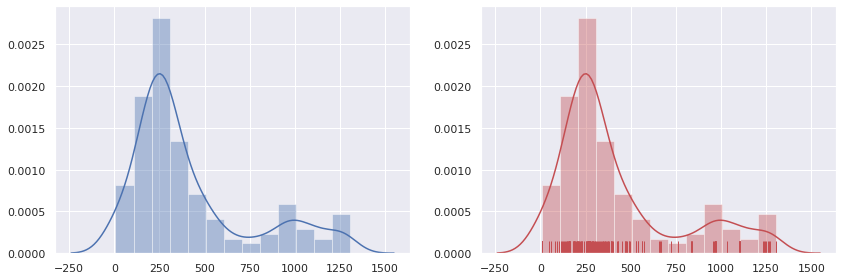

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np
from pylab import *

def plot_distances(d1, d2):
    
    sns.set(rc={"figure.figsize": (14, 10)})

    subplot(2,2,1)
    ax = sns.distplot(d1)

    subplot(2,2,2)
    ax = sns.distplot(d1, rug=True, hist=True, color="r")

    plt.show()
    '''
    fig,axes=plt.subplots(1,2)
    sns.distplot(d1,ax=axes[0])
    plt.grid(True)
    sns.distplot(d2,rug=True,ax=axes[1], color="r")
    plt.show()
    '''


plot_distances(dist0, dist1)

In [159]:
#Export data to plot
X, X_, y = data.prepare_training_data(FeatureType.Divided, normalise=False,
                                                  cilyndrical=False)
X_train, X_test, X_train_, X_test_, y_train, y_test = train_test_split(X, X_, y,
                                                                       test_size=1-0.8, random_state=42)

y_pred = pd.DataFrame(y_predicted_orig)
y_true = pd.DataFrame(y_test_orig)

print('[Output] saving results ...')
y_true.to_csv(os.path.join(save_dir, 'y_true.csv'), header=False, index=False)
y_pred.to_csv(os.path.join(save_dir, 'y_pred.csv'), header=False, index=False)
X_test.to_csv(os.path.join(save_dir, 'x_test.csv'), header=False, index=False)

[Data] shape datas X:  (854, 16)
[Data] shape data y:  (854, 3)
[Data] len data total: 854
